# RL_Toy  
**Payam Mousavi**  
**Unbounce**  
**Oct 28, 2021** 

We attempt to solve the following problem: 
Given a bag of $N$ 2-dimensional shapes (e.g., rectangles, squares), train an RL agent (i.e., using REINFORCE or PPO) to place them sequentially on an $M\times N$ canvas. The preferences for the 'optimum' configuration will be specified in the **<em>reward<em>** function. 
    
TODO:  
    
**Monday and Tuesday**: 
* Create Environment + Shape class 
* Add reward functions: symmetry, distribution, (ordering if time?) 
* Make step function + test 
* Make reset function 
* Add requirements for openai gym + test that it can register 
* Think about 

**Wednesday and Thursday**: 
* Write up approach and results. 
* Present to group or Eimear. 

In [35]:
%matplotlib qt
from typing import Tuple, List, Dict, Optional, Union
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import torch
import torch.nn as nn
from numba import jit
from PIL import Image
# %matplotlib inline


## Helper Functions:

In [ ]:
def check_shape(env, shape_id):
    
    

## Play around

In [ ]:
x = np.zeros((5,5))
print(x)

s = np.ones((2,2))

x[:2, :2] = s
print(x)

## Objects

In [40]:
class Shape:
    """
    The Shapes object can create a single shape with given height, width, and integer ID
    """
    def __init__(self, Height, Width, ID, Label):
        self.height = Height
        self.width = Width
        self.id = ID
        self.area = self.height*self.width
        self.label = Label 
    def create_shape(self):
        return self.id * np.ones((self.height, self.width))
            
               
class Environment:
    """
    The Canvas to place shapes in. Creates the canvas, generates the shapes (randomly or manually), and has
    methods for placing a single shape, rendering the results. 
    
    """
    def __init__(self, shapes, canvas_dim):
        """
        shapes: list of object shapes
        canvas_dim: (H,W) > (rows, cols)
        """
        self.canvas_dim = canvas_dim # (H,W) tuple
        self.shapes = shapes
        self.canvas = np.zeros(self.canvas_dim)
        self.next_shape_id = shapes[0].id # first shape's id = 1 by default
        self.possible_actions = np.ones(self.canvas_dim, dtype=bool)
        self.num_shapes_inserted = 0 # keeps track of number of shapes already inserted
        self.canvas_cost = 0.0
        
    
    def _insert_shape(self, shape_id, coordinate, verbose=False):
        """
        Insert shape with shape_id in the desired coordinate
        """
        # Update the mask for the current shape_id:
        self.possible_actions = self._generate_mask(shape_id=shape_id)
        
        the_shape = next(s for s in self.shapes if s.id==shape_id)
        if self.possible_actions[coordinate] != False: # the shape can be placed there
            self.canvas[coordinate[0]:coordinate[0] + the_shape.height, 
                        coordinate[1]:coordinate[1] + the_shape.width] = the_shape.create_shape()
            self.num_shapes_inserted += 1 # used for rendering consistency
            if verbose:
                print('Shape successfully inserted!')
        else:
            if verbose:
                print('The shape does not fit in that spot! Try another coordinate')
        
        
        return self.canvas
        
    def step(self, action):
        """
        action : (shape_id, row, column)
        """
        if self.num_shapes_inserted != len(self.shapes): # Not all shapes have been placed
            self._insert_shape(shape_id = self.next_shape_id, 
                               coordinate = action, 
                               verbose = False)
        if self.num_shapes_inserted == len(self.shapes): # episode ends
            self.reward = self.evaluate() #TODO: fix this! We want reward not cost. evaluate gives the cost
            done = True
        else:
            self.reward = 0
            self.next_shape_id += 1        
         
        return self.canvas, self.reward, done
    
    def _generate_mask(self, shape_id):
        """
        Given the state of the canvas and the shape_id to be inserted, calculate the mask
        """
        the_shape = next(s for s in self.shapes if s.id==shape_id)
        h = the_shape.height # rows
        w = the_shape.width # columns
        shape_arr = the_shape.create_shape()
        
        mask = np.ones(self.canvas_dim, dtype=bool)
        for i in range(self.canvas_dim[0]): # rows: height
            for j in range(self.canvas_dim[1]): # columns: width
                # check if shape will go outside the canvas:
                if (j + w > self.canvas_dim[1]) or (i + h > self.canvas_dim[0]):
                    mask[i,j] = False
                    continue
                # check for overlap with other shapes:
                if np.multiply(shape_arr, self.canvas[i:i+h, j:j+w]).sum() != 0:
                    mask[i,j] = False
        self.possible_actions = mask
        return self.possible_actions
    
    def evaluate(self):
        """
        Rewards: Symmetry, Uniform distribution across canvas, Order of elements (not yet implemented)
        """
        # Convert to binary image:
        binary_canvas = np.where(self.canvas!=0, 1, self.canvas)
        
        # Symmetry:
        A_left = binary_canvas[:,:self.canvas_dim[1]//2]
        A_right = binary_canvas[:,self.canvas_dim[1]//2:]
        cost_sym = np.abs(A_left - np.fliplr(A_right)) # Looking at symmetry around y-axis only
        cost_sym = cost_sym.sum() / np.count_nonzero(binary_canvas)
        
        # Distribution in vertical dimension: #TODO: make it more efficient?
        count = 0
        distances = []
        for i in range(len(self.canvas)):
            if i==len(self.canvas)-1: # distance from the bottom
                distances.append(count+1)
            elif all(v == 0 for v in self.canvas[i,:]):
                count += 1
            elif any(v != 0 for v in self.canvas[i,:]) and count!=0:
                distances.append(count)
                count = 0
        cost_dist = (np.max(distances) - np.min(distances)) / np.mean(distances)
        
        # Desired Order:
        #TODO later
        
        self.canvas_cost = cost_sym + cost_dist # could consider biasing one over the other
        
        return self.canvas_cost
        
    
    def render(self):
        my_colors = ["white", "blue", "red", "green", "cyan", "orange", "pink"]
        my_colors = my_colors[0:self.num_shapes_inserted+1]
        cmap = colors.ListedColormap(my_colors)
                
        plt.figure(figsize=(12,12))
        plt.imshow(self.canvas, cmap=cmap)
        plt.xticks(np.arange(-0.5, self.canvas_dim[1], 1.0))
        plt.yticks(np.arange(-0.5, self.canvas_dim[0], 1.0))
        plt.grid()
        plt.tight_layout()
#         ax = plt.gca()
#         ax.axes.xaxis.set_visible(False)
#         ax.axes.yaxis.set_visible(False)

#         plt.xlabel('Width')
#         plt.ylabel('Height')    
#         plt.title('CANVAS')

#         plt.axis('off')
        plt.show()
#         plt.savefig('test.png', bbox_inches = 'tight', pad_inches=0)

        
        return True
    
    def reset(self):
        """
        Reset the environment to its original form
        """
        self.canvas = np.zeros(self.canvas_dim)
        self.next_shape_id = shapes[0].id # first shape's id = 1 by default
        self.possible_actions = np.ones(self.canvas_dim, dtype=bool)
        self.num_shapes_inserted = 0 # keeps track of number of shapes already inserted
        self.canvas_cost = 0.0
        return True
    

## Creating Custom gym environment:

In [ ]:
# Source: https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html
# Example: https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/5_custom_gym_env.ipynb#scrollTo=rzevZcgmJmhi

import gym
from gym import spaces

class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, arg1, arg2, ...):
    super(CustomEnv, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
    self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
    # Example for using image as input (channel-first; channel-last also works):
    self.observation_space = spaces.Box(low=0, high=255,
                                        shape=(N_CHANNELS, HEIGHT, WIDTH), dtype=np.uint8)

  def step(self, action):
    ...
    return observation, reward, done, info
  def reset(self):
    ...
    return observation  # reward, done, info can't be included
  def render(self, mode='human'):
    ...
  def close (self):
    ...

## Policy Network:

2 Networks need to be specified: 
* First the feature selection network that takes as input the image (say RGB), passes it through a CNN to extract a 1D feature vector. This is then concatenated with a one-hot-encoded id associated with the next shape in the queue. 
* The second network is the policy network that takes as input the above feature vector and maps it to a set of actions. The actions will be masked to ensure no 'illegal' placements are done.

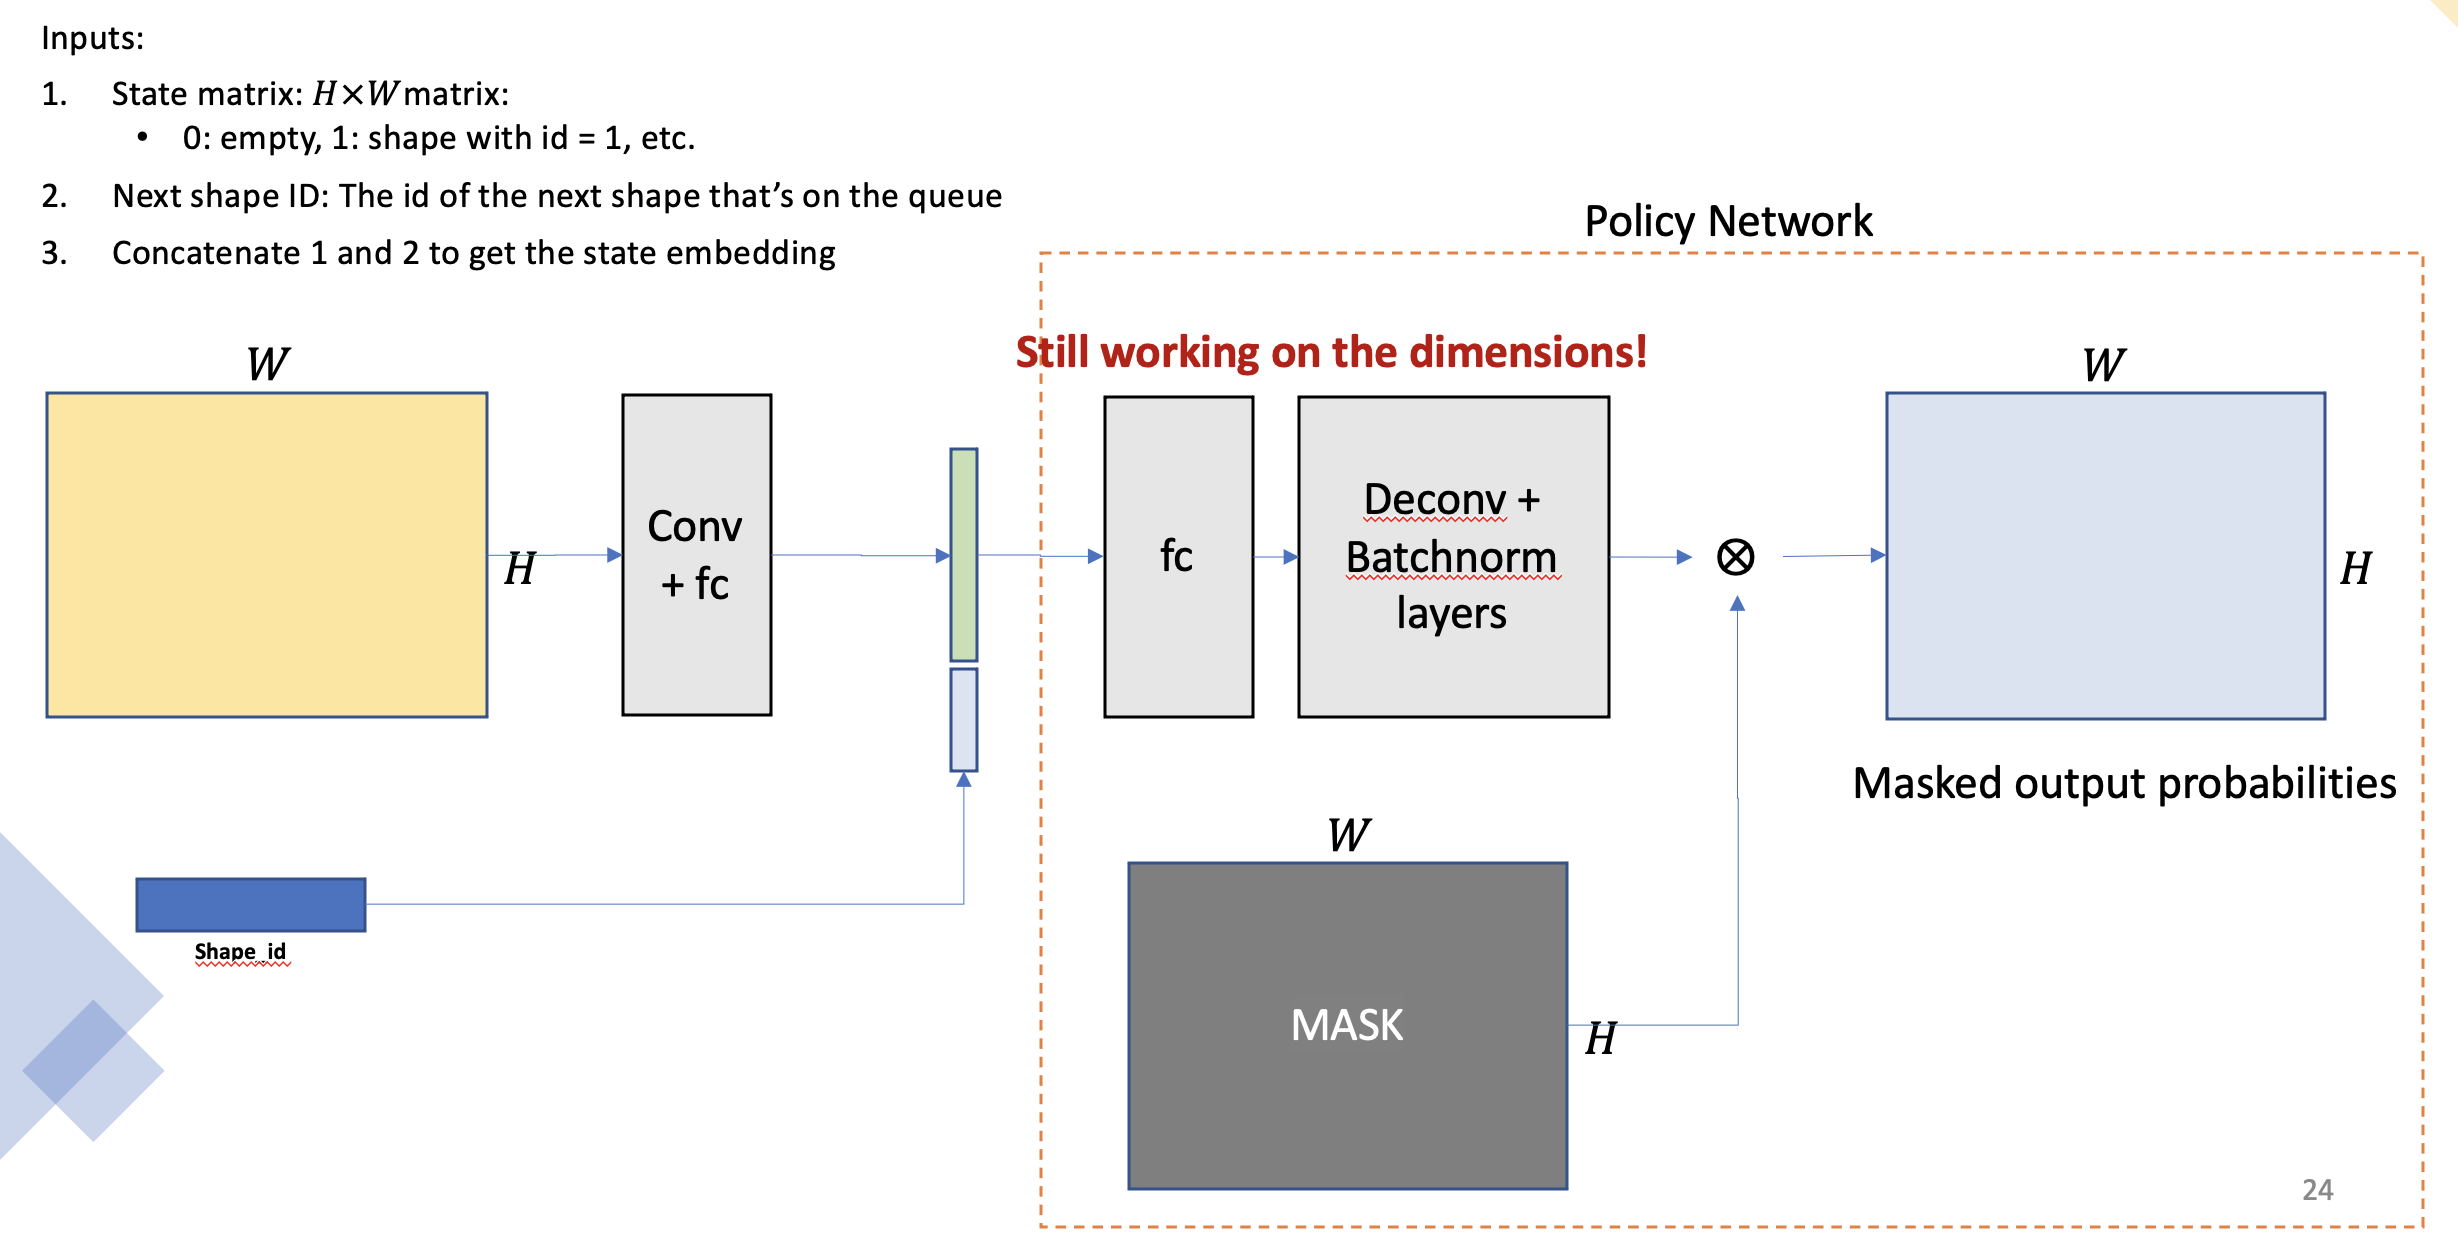

In [37]:
# To lookup equations for input/output sizes, see documentation: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
class CNNFeatures(nn.Module):
    def __init__(self, canvas_dim=(32,16), feature_dim=122): # 122 is picked as 128 - Number of shapes. Want the full feature vector to be a power of 2
        super(CNNFeatures, self).__init__()
        self.cnn = nn.Sequential(nn.Conv2d(in_channels=3, 
                                           out_channels=16, 
                                           kernel_size=4, 
                                           stride=2, 
                                           padding=0), 
                                 nn.ReLU(),
                                 nn.Conv2d(in_channels=16, 
                                           out_channels=32, 
                                           kernel_size=2, 
                                           stride=1, 
                                           padding=0), 
                                 nn.ReLU(),
                                 nn.Flatten())
        
        # Compute shape by doing one forward pass
        test_canvas = np.zeros((1, 3, 32,16)) # first dim is batch size, second is the channels (rgb)
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(test_canvas).float()).shape[1]
            
        self.linear = nn.Sequential(nn.Linear(n_flatten, feature_dim), nn.ReLU())
        
    def forward(self, x):
        return self.linear(self.cnn(x))
    

class Policy(nn.Module):
    def __init__(self, canvas_dim=(32,16)):
        super(Policy, self).__init__()
        self.deconv = nn.Sequential(nn.ConvTranspose2d(in_channels=4, 
                                                       out_channels=2, 
                                                       kernel_size=2, 
                                                       stride=2, 
                                                       padding=0), 
                                    nn.BatchNorm2d(2), # out_channels from above
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(in_channels=2, 
                                                       out_channels=1, 
                                                       kernel_size=2, 
                                                       stride=2, 
                                                       padding=0), 
                                    nn.BatchNorm2d(1)) # out_channels from above
                                    
    def forward(self, x):
        x = x.view(-1, 4, 8, 4) # reshape into size, assumes 128x1 input vector
        print(self.deconv(x).shape)
        x = self.deconv(x)
        return nn.Softmax(x)
    


In [32]:
# x = torch.randn(128)
test_canvas = np.zeros(128)

rl_policy = Policy()
rl_policy.forward(x=torch.as_tensor(test_canvas).float())

torch.Size([1, 1, 32, 16])
Softmax(
  dim=tensor([[[[-0.0001, -0.0004, -0.0001, -0.0004, -0.0001, -0.0004, -0.0001,
             -0.0004, -0.0001, -0.0004, -0.0001, -0.0004, -0.0001, -0.0004,
             -0.0001, -0.0004],
            [-0.0003,  0.0009, -0.0003,  0.0009, -0.0003,  0.0009, -0.0003,
              0.0009, -0.0003,  0.0009, -0.0003,  0.0009, -0.0003,  0.0009,
             -0.0003,  0.0009],
            [-0.0001, -0.0004, -0.0001, -0.0004, -0.0001, -0.0004, -0.0001,
             -0.0004, -0.0001, -0.0004, -0.0001, -0.0004, -0.0001, -0.0004,
             -0.0001, -0.0004],
            [-0.0003,  0.0009, -0.0003,  0.0009, -0.0003,  0.0009, -0.0003,
              0.0009, -0.0003,  0.0009, -0.0003,  0.0009, -0.0003,  0.0009,
             -0.0003,  0.0009],
            [-0.0001, -0.0004, -0.0001, -0.0004, -0.0001, -0.0004, -0.0001,
             -0.0004, -0.0001, -0.0004, -0.0001, -0.0004, -0.0001, -0.0004,
             -0.0001, -0.0004],
            [-0.0003,  0.0009, -0.0003, 

Softmax(
  dim=tensor([[[[-0.0001, -0.0004, -0.0001, -0.0004, -0.0001, -0.0004, -0.0001,
             -0.0004, -0.0001, -0.0004, -0.0001, -0.0004, -0.0001, -0.0004,
             -0.0001, -0.0004],
            [-0.0003,  0.0009, -0.0003,  0.0009, -0.0003,  0.0009, -0.0003,
              0.0009, -0.0003,  0.0009, -0.0003,  0.0009, -0.0003,  0.0009,
             -0.0003,  0.0009],
            [-0.0001, -0.0004, -0.0001, -0.0004, -0.0001, -0.0004, -0.0001,
             -0.0004, -0.0001, -0.0004, -0.0001, -0.0004, -0.0001, -0.0004,
             -0.0001, -0.0004],
            [-0.0003,  0.0009, -0.0003,  0.0009, -0.0003,  0.0009, -0.0003,
              0.0009, -0.0003,  0.0009, -0.0003,  0.0009, -0.0003,  0.0009,
             -0.0003,  0.0009],
            [-0.0001, -0.0004, -0.0001, -0.0004, -0.0001, -0.0004, -0.0001,
             -0.0004, -0.0001, -0.0004, -0.0001, -0.0004, -0.0001, -0.0004,
             -0.0001, -0.0004],
            [-0.0003,  0.0009, -0.0003,  0.0009, -0.0003,  0.0009, 

In [ ]:
test_canvas = np.zeros(128)
test_canvas_reshaped = test_canvas.reshape((-1, 4, 8, 4))

# test_input = torch.randn((1,4,8,4))
# m = nn.ConvTranspose2d(4, 2, 2, stride=2, padding=0)
# print(m(test_input).shape)

test_input = torch.randn((1,4,8,4))
m = nn.ConvTranspose2d(4, 2, 2, stride=2, padding=0)
print(m(test_input).shape)

test_input = torch.randn((1,2,16,8))
m = nn.ConvTranspose2d(2, 1, 2, stride=2, padding=0)
m(test_input).shape

In [ ]:
test_canvas = np.zeros((1, 3, 32,16))
feature_policy = CNNFeatures()
output = feature_policy.forward(x=torch.as_tensor(test_canvas).float())
print(output.shape[1])

In [ ]:
# class Policy(nn.Module):
#     pass

# class REINFORCE():
#     """
#     The REINFORCE agent that takes in the Simulator object (and the bag of shapes) and trains to place
#     them optimally on the canvas
#     """
#     def __init__(self):
#         pass
    
#     def policy_network(self):
#         pass
    
#     def train(self):
#         pass
    
#     def evaluate(self):
#         pass
    
#     def visualize(self):
#         pass
    
#     def predict(self):
#         pass

## Testing:

In [41]:
headline = Shape(Height=2, Width=4, ID=1, Label='headline')
paragraph = Shape(Height=4, Width=8, ID=2, Label='paragraph')
cta = Shape(Height=2, Width=2, ID=3, Label='cta')
features_1 = Shape(Height=4, Width=3, ID=4, Label='features')
features_2 = Shape(Height=4, Width=3, ID=5, Label='features')
features_3 = Shape(Height=4, Width=3, ID=6, Label='features')

shapes = [headline, paragraph, cta, features_1, features_2, features_3]

# sort shapes by area
shapes_areas = [-s.height*s.width for s in shapes]
sorted_indices = np.argsort(shapes_areas)
shapes_sorted_descending = np.array(shapes)[sorted_indices]

In [42]:
env = Environment(shapes=shapes_sorted_descending, canvas_dim=(32,16))
env._generate_mask(shape_id=shapes[0].id)
env._insert_shape(shape_id=1, coordinate=(1,3))
env._insert_shape(shape_id=2, coordinate=(4,1))
env._insert_shape(shape_id=3, coordinate=(8,4))
env._insert_shape(shape_id=4, coordinate=(10,3))
env._insert_shape(shape_id=5, coordinate=(15,4))
env._insert_shape(shape_id=6, coordinate=(21,4))

# print(env.canvas)
env.render()

# print(env.evaluate())




True

In [ ]:
# binary_canvas = np.where(env.canvas!=0, 1, env.canvas)
# # Symmetry:
# A_left = binary_canvas[:,:env.canvas_dim[1]//2]
# A_right = binary_canvas[:,env.canvas_dim[1]//2:]
# cost_sym = np.abs(A_left - np.fliplr(A_right)) # Looking at symmetry around y-axis only
# cost_sym = cost_sym.sum() / np.count_nonzero(binary_canvas)
# print(cost_sym)

In [ ]:
env2 = Environment(shapes=shapes_sorted_descending, canvas_dim=(32,16))
env2._insert_shape(shape_id=3, coordinate=(8,3))
env2._insert_shape(shape_id=3, coordinate=(8,11))
env2.render()

binary_canvas = np.where(env2.canvas!=0, 1, env2.canvas)
A_left = binary_canvas[:,:env2.canvas_dim[1]//2]
A_right = binary_canvas[:,env2.canvas_dim[1]//2:]
cost_sym = np.abs(A_left - np.fliplr(A_right))
cost_sym = cost_sym.sum()
print(cost_sym)

In [ ]:
xx = np.ones((5,5))
xx.sum()

In [ ]:
# test binary canvas:
